In [1]:
# QUESTION 1

import pandas as pd
import networkx as nx

# Load node information from global-cities.dat
# The file is pipe-delimited and the second column contains the node ids.
nodes = pd.read_csv("global-cities.dat", delimiter="|", header=None, names=["code", "node_id", "city"])
print("Number of nodes in global-cities.dat:", len(nodes))

# Load edge list from global-net.dat
# The file is space-delimited and contains two columns (source and target).
edges = pd.read_csv("global-net.dat", delimiter="\\s+", header=None, names=["source", "target"])
print("Number of raw edges in global-net.dat:", len(edges))

# Create an undirected graph
G = nx.Graph()

# Add nodes from the node file
G.add_nodes_from(nodes["node_id"])

# Add edges from the edge list
# Duplicates and reverse order entries will automatically be handled by the undirected graph.
for _, row in edges.iterrows():
    G.add_edge(row["source"], row["target"])

# Print the number of nodes and undirected edges in the graph
print("Graph has {} nodes and {} undirected edges.".format(G.number_of_nodes(), G.number_of_edges()))


Number of nodes in global-cities.dat: 3883
Number of raw edges in global-net.dat: 28284
Graph has 3883 nodes and 14142 undirected edges.


In [2]:
# QUESTION 2

# Compute connected components
components = list(nx.connected_components(G))
num_components = len(components)
print("Number of connected components:", num_components)

# Identify the largest component (by number of nodes)
largest_component_nodes = max(components, key=len)
G_largest = G.subgraph(largest_component_nodes).copy()

# Print the number of nodes and edges in the largest component
print("Largest component has {} nodes and {} undirected edges.".format(
    G_largest.number_of_nodes(), G_largest.number_of_edges()))

Number of connected components: 266
Largest component has 3618 nodes and 14142 undirected edges.


In [3]:
# QUESTION 3

# Create a mapping from node IDs to city names:
city_mapping = nodes.set_index("node_id")["city"].to_dict()

# Compute the degree of each node in the largest component (G_largest)
degree_dict = dict(G_largest.degree())

# Sort the nodes by degree in descending order and take the top 10
top10 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes (by highest degree) in the largest component (G):")
for node, deg in top10:
    # Retrieve the city name from the node's attribute; if missing, use the mapping as a fallback.
    city_name = G_largest.nodes[node].get("city", city_mapping.get(node, "Unknown"))
    print(f"{city_name}: {deg} connections")

Top 10 nodes (by highest degree) in the largest component (G):
Paris: 250 connections
London (GB): 242 connections
Frankfurt: 237 connections
Amsterdam: 192 connections
Moscow: 186 connections
Chicago: 184 connections
New York: 179 connections
Atlanta: 172 connections
Dallas/Fort Worth: 147 connections
Houston: 144 connections


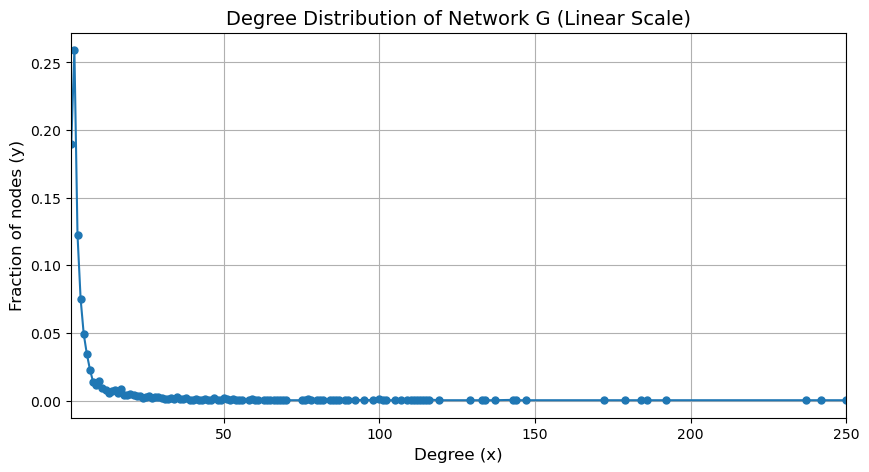

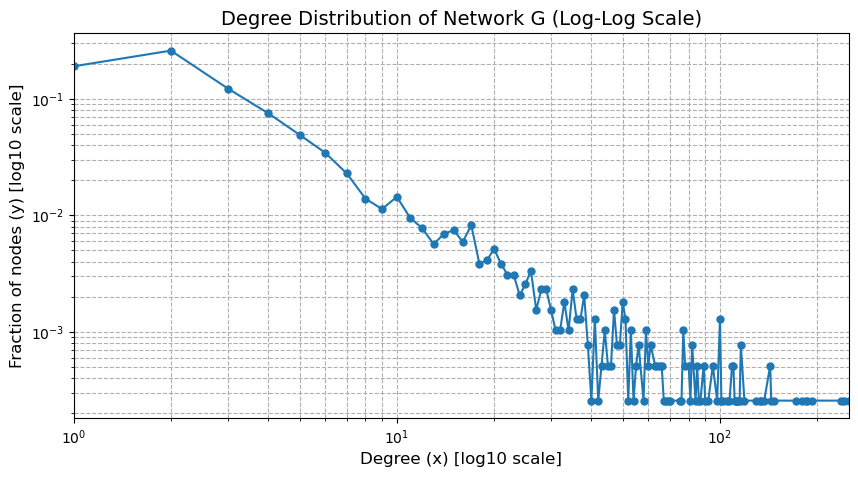

In [4]:
# QUESTION 4

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Compute degree for each node in G
degree_sequence = [d for n, d in G.degree()]
# Count frequency of each degree value (filter out degree 0, if any)
degree_counts = Counter(degree for degree in degree_sequence if degree > 0)

# Total number of nodes (for fraction calculation)
N = G.number_of_nodes()

# Build sorted arrays for x (degree) and y (fraction of nodes with that degree)
x = np.array(sorted(degree_counts.keys()))
y = np.array([degree_counts[k] / N for k in x])

# Plot on a Linear Scale
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'o-', markersize=5)
plt.xlabel("Degree (x)", fontsize=12)
plt.ylabel("Fraction of nodes (y)", fontsize=12)
plt.title("Degree Distribution of Network G (Linear Scale)", fontsize=14)
plt.xlim(x[0], x[-1])
plt.grid(True)
# Save the linear scale plot as PNG
plt.savefig("degree_distribution_linear.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot on a Log-Log Scale
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'o-', markersize=5)
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlabel("Degree (x) [log10 scale]", fontsize=12)
plt.ylabel("Fraction of nodes (y) [log10 scale]", fontsize=12)
plt.title("Degree Distribution of Network G (Log-Log Scale)", fontsize=14)
plt.xlim(x[0], x[-1])
plt.grid(True, which="both", ls="--")
# Save the log-log plot as PNG
plt.savefig("degree_distribution_loglog.png", dpi=300, bbox_inches="tight")
plt.show()


In [7]:
# QUESTION 5

# Extract the largest connected component from G
components = nx.connected_components(G)
largest_component_nodes = max(components, key=len)
G_largest = G.subgraph(largest_component_nodes).copy()

# Compute the (unweighted) diameter of G_largest
diameter = nx.diameter(G_largest)
print("Diameter of the giant component:", diameter)

# Compute eccentricity for each node in G_largest
ecc = nx.eccentricity(G_largest)

# Pick a node whose eccentricity equals the diameter; that node is one end of a longest shortest path
for node, e in ecc.items():
    if e == diameter:
        source = node
        break

# Find a target node such that the shortest path from 'source' equals the diameter
for target in G_largest.nodes():
    if nx.shortest_path_length(G_largest, source=source, target=target) == diameter:
        longest_path = nx.shortest_path(G_largest, source=source, target=target)
        break

# Convert node IDs in the longest_path to city names using a fallback:
# first check if the "city" attribute exists, otherwise fallback to city_mapping (from earlier)
longest_path_cities = [G_largest.nodes[n].get("city", city_mapping.get(n, "Unknown")) for n in longest_path]

print("Longest (unweighted) shortest path between two cities:")
print(" -> ".join(longest_path_cities))

Diameter of the giant component: 17
Longest (unweighted) shortest path between two cities:
Brize Norton -> Georgetown (XV) -> Mount Pleasant -> Punta Arenas -> Concepcion (CL) -> Santiago (CL) -> Buenos Aires -> Auckland -> Brisbane -> Port Moresby -> Lae -> Indagen -> Konge -> Kabwum -> Satwag -> Derim -> Yalumet -> Wasu


In [14]:
# QUESTION 6

# Function to find a node by its city name (case-insensitive)
def find_node_by_city(graph, target_city):
    for node, data in graph.nodes(data=True):
        # Attempt to get the city attribute; if not found, fallback to city_mapping
        city_name = data.get("city", city_mapping.get(node, "")).lower()
        if city_name == target_city.lower():
            return node
    return None

# Look for Canberra and Cape Town nodes by matching the city attribute
source_node = find_node_by_city(G, "Canberra")
destination_node = find_node_by_city(G, "Cape Town")

if source_node is None or destination_node is None:
    print("Could not find nodes for Canberra or Cape Town in the network.")
else:
    # Compute the unweighted shortest path (i.e. minimum number of flights)
    route = nx.shortest_path(G, source=source_node, target=destination_node)
    num_flights = len(route) - 1  # flights are the edges between airports

    # Convert each node in the route to its city name, using the same fallback method
    route_cities = [G.nodes[n].get("city", city_mapping.get(n, "Unknown")) for n in route]

    print("Smallest number of flights from Canberra to Cape Town:", num_flights)
    print("Route (airport names):")
    print(" -> ".join(route_cities))

Smallest number of flights from Canberra to Cape Town: 3
Route (airport names):
Canberra -> Melbourne (AU) -> Mauritius -> Cape Town


In [16]:
# QUESTION 7

from operator import itemgetter

# Compute betweenness centrality for all nodes in G (unweighted)
betweenness = nx.betweenness_centrality(G)

# Sort the betweenness centrality values in descending order and select the top 10
top10_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 cities by betweenness centrality:")
for node, value in top10_betweenness:
    # Retrieve city name using the node attribute "city" if available,
    # otherwise fallback to the city_mapping dictionary
    city_name = G.nodes[node].get("city", city_mapping.get(node, "Unknown"))
    print(f"{city_name}: {value:.5f}")

Top 10 cities by betweenness centrality:
Paris: 0.08110
London (GB): 0.07378
Anchorage: 0.07077
Singapore: 0.06542
New York: 0.06015
Los Angeles (US): 0.05751
Frankfurt: 0.05693
Port Moresby: 0.05584
Tokyo: 0.05230
Seattle: 0.04547
